<a href="https://colab.research.google.com/github/t2thomas/wordle-helper.github.io/blob/main/NaiveMarketSimulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
!pip install matplotlib

In [67]:
SIM_START_TIME = "2024-08-30 09:30:00"
SIM_END_TIME = "2024-08-30 16:00:00"
SIM_PARAM_NUM_ORDERS = 1000
SIM_PARAM_NUM_PARTICIPANTS = 100

SIM_PRICE_START_MIDPOINT = 100
SIM_PROB_BUY_ORDERS = 0.5
SIM_PROB_MARKET_ORDER = 0.5

Defining Participants, Orders, Executions

In [68]:
class Participant:
    def __init__(self, **kwargs):
        """
        Initializes a Participant object with flexible ID handling.

        Args:
            **kwargs: Keyword arguments containing the ID information.
                      Expected format: {'id_type': 'id_value'}
                      e.g., {'FDID': '12345'}, {'CCID': 'ABC678'}
        """
        self._ids = kwargs

    def get_id(self, id_type):
        """
        Returns the ID value for the specified ID side.

        Args:
            id_type (str): The side of ID to retrieve (e.g., 'FDID', 'CCID').

        Returns:
            str or None: The ID value if found, otherwise None.
        """
        return self._ids.get(id_type)

    def set_id(self, id_type, id_value):
        """
        Sets the ID value for the specified ID side.

        Args:
            id_type (str): The type of ID to set.
            id_value (str): The ID value to set.
        """
        self._ids[id_type] = id_value

    def has_id_type(self, id_type):
        """
        Checks if the Participant has an ID of the specified type.

        Args:
            id_type (str): The type of ID to check.

        Returns:
            bool: True if the ID type is present, otherwise False.
        """
        return id_type in self._ids

    def __str__(self):
        return f"Participant({self._ids})"  # Display the entire _ids dictionary


In [69]:
# Testing usage
participant1 = Participant(FDID='12345')
participant2 = Participant(CCID='ABC678')

print(participant1)  # Output: Participant(IDs: {'FDID': '12345'})
print(participant2)  # Output: Participant(IDs: {'CCID': 'ABC678'})

print(participant1.get_id('FDID'))  # Output: 12345
print(participant1.get_id('CCID'))  # Output: None

participant1.set_id('CCID', 'XYZ901')
print(participant1)  # Output: Participant(IDs: {'FDID': '12345', 'CCID': 'XYZ901'})

print(participant1.has_id_type('CCID'))  # Output: True

Participant({'FDID': '12345'})
Participant({'CCID': 'ABC678'})
12345
None
Participant({'FDID': '12345', 'CCID': 'XYZ901'})
True


In [70]:
from enum import Enum
import numpy as np

class OrderSide(Enum):
  """Enum for order types."""
  BUY = 'B'
  SELL = 'S'
  def __str__(self):
    return self.value  # Return the enum value instead of the name

class Order:
  """Base class for an order object."""

  def __init__(self, displayed=False, quantity=0, order_side=OrderSide.BUY, price=0.0, ts=None, symbol="",participant=None):
    """Initializes an Order object.

    Args:
      displayed: A boolean indicating whether the order is displayed.
      quantity: An integer representing the quantity of the order.
      order_side: An OrderSide enum value representing the type of order (BUY or SELL).
      price: A float representing the price of the order.
      ts: A datetime object representing the timestamp of the order. Defaults to the current time.
      symbol: A string representing the symbol of the instrument being ordered.
      participant: A Participant object representing the participant who placed the order.
    """
    self.displayed = displayed
    self.quantity = quantity
    self.order_side = order_side
    self.price = price
    self.ts = ts or datetime.now()
    self.symbol = symbol
    self.participant = participant  # Add participant attribute

  def __str__(self):
    """String representation of the Order object."""
    return (f"Order(displayed={self.displayed}, quantity={self.quantity}, "
            f"order_side={self.order_side}, price={self.price}, "  # Call str(self.order_side)
            f"ts={self.ts}, symbol={self.symbol}, "
            f"participant={self.participant})")  # Call str(self.participant)


  @classmethod
  def populate_single_random_order(cls, timestamp, participants, orderbook=None):
      """
      Class method to generate a single Order instance using the provided timestamp
      and optional orderbook, calculating the midpoint to generate the order price.
      If orderbook is not provided, a default midpoint of 100 is used.

      Args:
          timestamp (pd.Timestamp): The timestamp to use for the order.
          participants (list[Participant]): A list of Participant instances to choose from.
          orderbook (Orderbook, optional): The current orderbook object. Defaults to None.

      Returns:
          Order: An Order instance.
      """
      midpoint = SIM_PRICE_START_MIDPOINT  # Default midpoint

      # Bernoulli(0.5) for order_side
      order_side = OrderSide.BUY if np.random.binomial(1, SIM_PROB_BUY_ORDERS) == 1 else OrderSide.SELL

      if orderbook is not None:
          best_bid_data = orderbook.get_best_bid()
          best_offer_data = orderbook.get_best_offer()

          if best_offer_data and best_bid_data:
            midpoint = (best_offer_data['price'] + best_bid_data['price'])/2

          at_market_price = np.random.binomial(1, SIM_PROB_MARKET_ORDER) == 1
          if best_offer_data is not None and order_side == OrderSide.BUY:
            price = best_offer_data['price'] if at_market_price \
                                            else best_offer_data['price'] + np.random.normal(0,1)
            price = max(1, price)  # Ensure price is not negative
          elif best_bid_data is not None and order_side == OrderSide.SELL:
            price = best_bid_data['price'] if at_market_price \
                                            else best_bid_data['price'] + np.random.normal(0,1)
          else:
            price = midpoint + np.random.normal(0, 1)
      else:
          price = midpoint + np.random.normal(0, 1)

      displayed = np.random.binomial(1, 0.01) == 1  # Bernoulli(0.01) for displayed
      quantity = max(1, np.random.poisson(10))  # Poisson(10) for quantity

      # Choose a random participant from the list
      participant = np.random.choice(participants)

      # Create and return an Order instance using cls
      return cls(displayed=displayed, quantity=quantity, order_side=order_side,
                  price=price, ts=timestamp, symbol='TSLA', participant=participant)

In [71]:
class NBBOChange:
    """Represents a change in the National Best Bid and Offer (NBBO)."""

    def __init__(self, best_bid, best_offer, timestamp=None):
        """
        Initializes an NBBOChange object.

        Args:
            best_bid (float or None): The best bid price after the change.
            best_offer (float or None): The best offer price after the change.
            timestamp (datetime, optional): The timestamp of the NBBO change.
                                            Defaults to the current time.
        """
        self.best_bid = best_bid
        self.best_offer = best_offer
        self.timestamp = timestamp or datetime.now()  # Use current time if not provided


In [72]:
from enum import Enum
from datetime import datetime

#class Liquidity(Enum):
#  """Enum for liquidity sides."""
#  TAKING = 'taking'
#  PROVIDING = 'providing'
#  def __str__(self):
#    return self.value  # Return the enum value instead of the name

class Execution:
  """Class for an execution object."""

  def __init__(self, quantity=0, price=0.0, ts=None, symbol="", buyside_participant = None, sellside_participant=None):
      """Initializes an Execution object.

      Args:
        quantity: An integer representing the quantity of the execution.
        price: A float representing the price of the execution.
        ts: A datetime object representing the timestamp of the execution. Defaults to the current time.
        symbol: A string representing the symbol of the executed instrument.
        buyside_participant = Participant object representing the buy side participant.
        sellside_participant = Participant object representing the sell side participant.
      """
      self.quantity = quantity
      self.price = price
      self.ts = ts or datetime.now()
      self.symbol = symbol
      self.buyside_participant = buyside_participant
      self.sellside_participant = sellside_participant

  def __str__(self):
      """Returns a string representation of the Execution object."""
      return f"Execution(ts={self.ts}, price={self.price}, quantity={self.quantity}, buyer_id={self.buyer_id}, seller_id={self.seller_id})"

Create OrderBook

In [73]:
class Orderbook:
    """Represents an order book snapshot."""

    def __init__(self, ts=None, entries=None):
        """
        Initializes an Orderbook object.

        Args:
            ts (datetime, optional): Timestamp of the order book snapshot. Defaults to current time.
            entries (list[dict], optional): List of order book entries. Defaults to an empty list.
                Each entry is a dictionary with the following keys:
                    - 'price' (float): The price level.
                    - 'orders' (list[dict]): A list of orders at that price level.
                        Each order is a dictionary with the following keys:
                            - 'participant' (Participant): The participant who placed the order.
                            - 'quantity' (int): The quantity of the order.
                            - 'order_reference' (Order): A pointer to the Order object.
        """
        self.ts = ts # Not optional, must be provided
        self.entries = entries or []
        self.sort_entries()

    @classmethod
    def from_order(cls, order):
        """
        Creates an Orderbook object from an initial Order object.

        Args:
            order (Order): The initial order to populate the order book with.

        Returns:
            Orderbook: An Orderbook object initialized with the given order.
        """
        return cls(
            ts=order.ts,  # Use the order's timestamp
            entries=[
                {
                    'price': order.price,
                    'orders': [
                        {
                            'participant': order.participant,
                            'quantity': order.quantity,
                            'order_reference': order
                        }
                    ]
                }
            ]
        )

    def sort_entries(self):
        """Sorts the entries in the order book based on price and order side."""
        self.entries.sort(key=lambda entry: (entry['price'] if any(order_dict['order_reference'].order_side == OrderSide.BUY
                                                                     for order_dict in entry['orders'])
                                                else -entry['price']), reverse=True)

    def add_order(self, order):
        """
        Adds an Order object to the order book and resolves any resulting executions.

        Args:
            order (Order): The Order object to add.

        Returns:
            tuple: A tuple containing the list of Execution objects and
                   an NBBOChange object (or None if NBBO didn't change).
        """
        self.ts = order.ts  # Update the timestamp
        # Add the order to the order book
        entry_found = False
        for entry in self.entries:
            if entry['price'] == order.price:
                entry['orders'].append({
                    'participant': order.participant,
                    'quantity': order.quantity,
                    'order_reference': order
                })
                entry_found = True
                break

        if not entry_found:
            self.entries.append({
                'price': order.price,
                'orders': [
                    {
                        'participant': order.participant,
                        'quantity': order.quantity,
                        'order_reference': order
                    }
                ]
            })
        self.sort_entries()

        # Resolve executions
        executions = self.resolve_executions(order.ts)  # Call resolve_executions to handle executions

        # Check if NBBO changed and create NBBOChange object, handle None cases
        best_bid = self.get_best_bid()
        best_offer = self.get_best_offer()

        # Check if best_bid or best_offer is None before accessing 'price'
        bid_price = best_bid['price'] if best_bid else None
        offer_price = best_offer['price'] if best_offer else None

        nbbo_change = NBBOChange(bid_price, offer_price, timestamp=order.ts)

        return executions, nbbo_change

    def get_best_bid(self):
        """
        Returns the best bid price and quantity in the order book.

        Returns:
            dict or None: A dictionary containing the best bid price and quantity,
                          or None if no bids are found.
                          Format: {'price': float, 'quantity': int}
        """
        # Directly access the first entry for the best bid (as entries are sorted)
        for entry in self.entries:
            if any(order_dict['order_reference'].order_side == OrderSide.BUY
                  for order_dict in entry['orders']):
                best_bid_price = entry['price']
                best_bid_quantity = sum(order_dict['quantity']
                                        for order_dict in entry['orders']
                                        if order_dict['order_reference'].order_side == OrderSide.BUY)
                return {'price': best_bid_price, 'quantity': best_bid_quantity}

        return None  # No bid prices found

    def get_best_offer(self):
        """
        Returns the best offer price and quantity in the order book.

        Returns:
            dict or None: A dictionary containing the best offer price and quantity,
                          or None if no offers are found.
                          Format: {'price': float, 'quantity': int}
        """
        # Directly access the first entry for the best offer (as entries are sorted)
        for entry in self.entries:
            if any(order_dict['order_reference'].order_side == OrderSide.SELL
                  for order_dict in entry['orders']):
                best_offer_price = entry['price']
                best_offer_quantity = sum(order_dict['quantity']
                                        for order_dict in entry['orders']
                                        if order_dict['order_reference'].order_side == OrderSide.SELL)
                return {'price': best_offer_price, 'quantity': best_offer_quantity}

        return None  # No offer prices found

    def resolve_executions(self, execution_timestamp):
        """
        Resolves executions based on best bid and offer prices and quantities,
        prioritizing earlier orders.

        Returns:
            list[Execution]: A list of Execution objects representing the executed trades.
        """
        executions = []
        while self._is_executable(self.get_best_bid(), self.get_best_offer()):
            executions.extend(self._execute_orders(execution_timestamp))
        return executions

    def _is_executable(self, best_bid_data, best_offer_data):
        """Helper function to check if an execution is possible."""
        return (best_bid_data is not None and
                best_offer_data is not None and
                best_bid_data['price'] >= best_offer_data['price'])

    def _execute_orders(self, execution_timestamp):
        """Helper function to execute orders and create Execution objects."""
        best_bid_data = self.get_best_bid()
        best_offer_data = self.get_best_offer()

        if best_bid_data is None or best_offer_data is None:
            return []  # No executable orders

        best_bid_price = best_bid_data['price']
        best_offer_price = best_offer_data['price']

        executions = []
        remaining_bid_quantity = best_bid_data['quantity']
        remaining_offer_quantity = best_offer_data['quantity']

        # Iterate through sorted entries for bids and offers
        for bid_entry in self.entries:
            if bid_entry['price'] == best_bid_price:
                for bid_order_dict in bid_entry['orders']:
                    if remaining_bid_quantity == 0 or remaining_offer_quantity == 0:
                        break  # No more executions possible

                    if bid_order_dict['order_reference'].order_side != OrderSide.BUY:
                        continue  # Skip non-buy orders in this entry

                    for offer_entry in self.entries:
                        if offer_entry['price'] == best_offer_price:
                            for offer_order_dict in offer_entry['orders']:
                                if remaining_bid_quantity == 0 or remaining_offer_quantity == 0:
                                    break  # No more executions possible

                                if offer_order_dict['order_reference'].order_side != OrderSide.SELL:
                                    continue  # Skip non-sell orders in this entry

                                bid_order = bid_order_dict['order_reference']
                                offer_order = offer_order_dict['order_reference']

                                # Execution logic (same as before)
                                execution_price = offer_order.price if bid_order.ts > offer_order.ts else bid_order.price
                                execution_quantity = min(bid_order.quantity, offer_order.quantity, remaining_bid_quantity, remaining_offer_quantity)

                                execution = Execution(
                                    quantity=execution_quantity,
                                    price=execution_price,
                                    ts=execution_timestamp,
                                    symbol=bid_order.symbol,
                                    buyside_participant=bid_order.participant,
                                    sellside_participant=offer_order.participant
                                )
                                executions.append(execution)

                                bid_order.quantity -= execution_quantity
                                offer_order.quantity -= execution_quantity
                                remaining_bid_quantity -= execution_quantity
                                remaining_offer_quantity -= execution_quantity

                                if bid_order.quantity == 0:
                                    self._remove_order(bid_order_dict, best_bid_price)
                                if offer_order.quantity == 0:
                                    self._remove_order(offer_order_dict, best_offer_price)

        self._remove_empty_price_levels()
        return executions

    def _get_sorted_orders(self, price, order_side):
        """Helper function to get sorted orders for a given price and order side."""
        return sorted([order_dict for entry in self.entries
                       for order_dict in entry['orders']
                       if entry['price'] == price and order_dict['order_reference'].order_side == order_side],
                      key=lambda order_dict: order_dict['order_reference'].ts)

    def _remove_order(self, order_dict, price):
        """Helper function to remove an order from the order book."""
        for entry in self.entries:
            if entry['price'] == price and order_dict in entry['orders']:
                entry['orders'].remove(order_dict)
                break

    def _remove_empty_price_levels(self):
        """Helper function to remove empty price levels from the order book."""
        self.entries = [entry for entry in self.entries if entry['orders']]  # Remove empty price levels


Generate random order time stamps within a day.



In [74]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Define the start and end times
start_time = pd.to_datetime(SIM_START_TIME, format="%Y-%m-%d %H:%M:%S").tz_localize("US/Eastern")
end_time = pd.to_datetime(SIM_END_TIME, format="%Y-%m-%d %H:%M:%S").tz_localize("US/Eastern")

# Generate 10000 random timestamps between the start and end times
random_numbers = np.random.uniform(size=SIM_PARAM_NUM_ORDERS)
time_range = end_time.value - start_time.value
random_timestamps = pd.to_datetime(start_time.value + random_numbers * time_range, utc=True).tz_convert("US/Eastern")

# Sort the timestamps
sorted_timestamps = random_timestamps.sort_values()

In [75]:
import uuid

# Create a list of 100 random participants with UUIDs
participants = [Participant(CCID=str(uuid.uuid4().hex)) for _ in range(SIM_PARAM_NUM_PARTICIPANTS)]

In [76]:
# Assuming you have a single timestamp in the variable 'timestamp'
initial_order = Order.populate_single_random_order(sorted_timestamps[1], participants)

# Now you can use the 'initial_order' object
print(initial_order)

Order(displayed=False, quantity=9, order_side=S, price=101.22401717728818, ts=2024-08-30 09:30:38.106748416-04:00, symbol=TSLA, participant=Participant({'CCID': '30710b4376184a17b43cc72420f51ccf'}))


In [77]:
# Create an Orderbook object using the from_order constructor
prev_orderbook = Orderbook.from_order(initial_order)
prev_orderbook.get_best_bid() , prev_orderbook.get_best_offer()

(None, {'price': 101.22401717728818, 'quantity': 9})

In [78]:
import copy

executions = []
nbbo_changes = []
orderbooks = [prev_orderbook]
orders = [initial_order]

for timestamp in sorted_timestamps[1:]:
    order = Order.populate_single_random_order(timestamp, participants, prev_orderbook)

    orderbook = copy.deepcopy(prev_orderbook)
    resolved_executions, nbbo_change = orderbook.add_order(order)

    orders.append(order)
    orderbooks.append(orderbook)
    nbbo_changes.append(nbbo_change)
    executions.extend(resolved_executions)

    prev_orderbook = orderbook

In [79]:
def display_time_range(orders, executions, nbbo_changes, start_time_str, end_time_str):
    """
    Displays Order, Execution, and NBBOChange objects within a time range.

    Args:
        orders (list[Order]): List of Order objects.
        executions (list[Execution]): List of Execution objects.
        nbbo_changes (list[NBBOChange]): List of NBBOChange objects.
        start_time_str (str): Start time in "YYYY-MM-DD HH:MM:SS" format.
        end_time_str (str): End time in "YYYY-MM-DD HH:MM:SS" format.
    """
    start_time = pd.Timestamp(start_time_str, tz='US/Eastern')
    end_time = pd.Timestamp(end_time_str, tz='US/Eastern')

    # Filter objects within the time range
    filtered_orders = [order for order in orders if start_time <= order.ts <= end_time]
    filtered_executions = [execution for execution in executions if start_time <= execution.ts <= end_time]
    filtered_nbbo_changes = [nbbo_change for nbbo_change in nbbo_changes
                             if start_time <= nbbo_change.timestamp <= end_time]

    # Create the plot
    plt.figure(figsize=(12, 6))

    # Plot NBBO changes
    bid_timestamps = [nbbo_change.timestamp for nbbo_change in filtered_nbbo_changes
                      if nbbo_change.best_bid is not None]
    bid_prices = [nbbo_change.best_bid for nbbo_change in filtered_nbbo_changes
                  if nbbo_change.best_bid is not None]
    plt.plot(bid_timestamps, bid_prices, '-', color='lightgreen', label='Best Bid', drawstyle='steps-post')

    offer_timestamps = [nbbo_change.timestamp for nbbo_change in filtered_nbbo_changes
                       if nbbo_change.best_offer is not None]
    offer_prices = [nbbo_change.best_offer for nbbo_change in filtered_nbbo_changes
                    if nbbo_change.best_offer is not None]
    plt.plot(offer_timestamps, offer_prices, '-', color='pink', label='Best Offer', drawstyle='steps-post')

    # Plot orders
    buy_orders = [order for order in filtered_orders if order.order_side == OrderSide.BUY]
    plt.plot([order.ts for order in buy_orders], [order.price for order in buy_orders],
             '^', markersize=8, color='green', label='Buy')
    sell_orders = [order for order in filtered_orders if order.order_side == OrderSide.SELL]
    plt.plot([order.ts for order in sell_orders], [order.price for order in sell_orders],
             'v', markersize=8, color='red', label='Sell')

    # Plot executions
    plt.plot([execution.ts for execution in filtered_executions],
             [execution.price for execution in filtered_executions],
             'x', markersize=8, color='black', label='Execution', alpha = 0.6)



    # Set plot details
    plt.title(f"Orders, Executions, and NBBO Changes from {start_time_str} to {end_time_str}")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

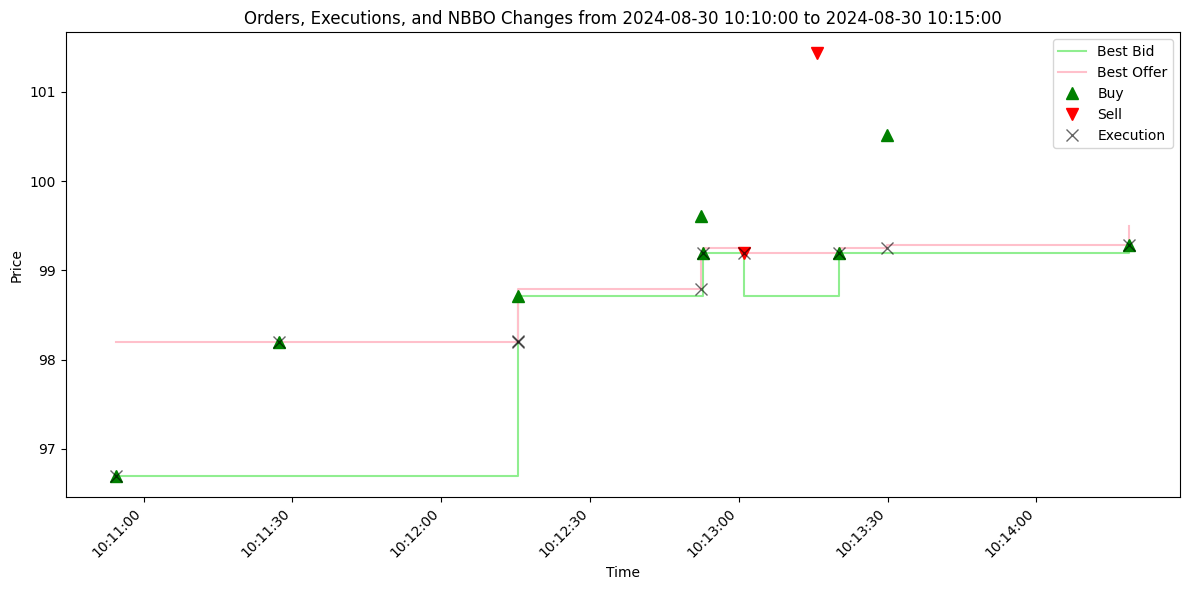

In [80]:
# Example usage
#orders = populate_orders(sorted_timestamps)
display_time_range(orders, executions, nbbo_changes, "2024-08-30 10:10:00", "2024-08-30 10:15:00")

In [81]:
print(orderbooks[100].ts,
orderbooks[100].entries)

2024-08-30 10:15:07.910984960-04:00 [{'price': 99.49813534288856, 'orders': [{'participant': <__main__.Participant object at 0x781a5bbbcb80>, 'quantity': 12, 'order_reference': <__main__.Order object at 0x781a48a9e6b0>}]}, {'price': 99.286878539267, 'orders': [{'participant': <__main__.Participant object at 0x781a48a9f760>, 'quantity': 9, 'order_reference': <__main__.Order object at 0x781a48a9ff10>}]}, {'price': 99.19101832576885, 'orders': [{'participant': <__main__.Participant object at 0x781a48a9fd90>, 'quantity': 9, 'order_reference': <__main__.Order object at 0x781a48a9cdc0>}]}, {'price': 98.71607757255752, 'orders': [{'participant': <__main__.Participant object at 0x781a48a9d990>, 'quantity': 6, 'order_reference': <__main__.Order object at 0x781a48a9d2d0>}]}, {'price': 96.69867221198542, 'orders': [{'participant': <__main__.Participant object at 0x781a48a9e500>, 'quantity': 11, 'order_reference': <__main__.Order object at 0x781a48a9d510>}]}, {'price': 96.2558269725453, 'orders': 